In [1]:
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import pickle
from tqdm import tqdm_notebook

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

In [3]:
def evaluate(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return prec, recall, f1

In [4]:
torch.cuda.set_device(3)

## Parameters Settings

In [5]:
#
# Classifier
# ---------------------
## focal loss
alpha = 1
gamma_pos = 6
gamma_neg = 2
grad_clip = 1
lambda_l1 = 0
weight_decay = 0   # lambda_l2

#
# VAT
# ---------------------
vat_xi = 1e-6
vat_eps_pos = 1e2
vat_eps_neg = 1e-1
vat_ip = 1

#
# Training process
# ---------------------
train_batch_size = 128
test_batch_size = 32

#
# Optimizer
# ---------------------
optim_type = 'rlars'       # ['adam', 'rlars']
learn_rate = 1e-4
adam_beta1 = 0.9
adam_beta2 = 0.999

max_epochs = 1600

## Model Declaration

### Conv1D

In [6]:
class ConvNet(nn.Module):
    def __init__(self, fc_dims, in_dim=256, out_dim=1):
        super(ConvNet, self).__init__()
        
        self.in_dim = in_dim
        self.conv1_dim = math.ceil(self.in_dim)
        self.conv2_dim = math.ceil(self.in_dim * 2)
        self.conv3_dim = math.ceil(self.in_dim)
        self.outdim_en1 = fc_dims[0]
        self.outdim_en2 = fc_dims[1]
        self.out_dim = out_dim
        
        self.model_conv = nn.Sequential(
            nn.Conv1d(in_channels=in_dim, out_channels=self.conv1_dim, kernel_size=2),
            nn.BatchNorm1d(self.conv1_dim),
            nn.ReLU(),
            nn.Conv1d(in_channels=self.conv1_dim, out_channels=self.conv2_dim, kernel_size=2),
            nn.BatchNorm1d(self.conv2_dim),
            nn.ReLU(),
            nn.Conv1d(in_channels=self.conv2_dim, out_channels=self.conv3_dim, kernel_size=2),
            nn.BatchNorm1d(self.conv3_dim),
            nn.ReLU(),
        )
        dropout_1 = 1 - 0.1
        dropout_2 = 1 - 0.2
        dropout_3 = 1 - 0.2
        self.model_fc = nn.Sequential(
            # FC 1
            nn.Dropout(dropout_1),
            nn.Linear(in_features=self.conv3_dim, out_features=self.outdim_en1),
            nn.BatchNorm1d(self.outdim_en1),
            nn.ReLU(),
            # FC 2
            nn.Dropout(dropout_2),
            nn.Linear(in_features=self.outdim_en1, out_features=self.outdim_en2),
            nn.BatchNorm1d(self.outdim_en2),
            nn.ReLU(),
            # FC 3
            nn.Dropout(dropout_3),
            nn.Linear(in_features=self.outdim_en2, out_features=self.out_dim),
            nn.Sigmoid(),
            nn.Softmax()
        )
        
        print("conv_dim = [{}, {}, {}]".format(self.conv1_dim, self.conv2_dim, self.conv3_dim))
        print("fc_dim = [{}/{}, {}/{}, {}/{}, {}]".format(self.conv3_dim, dropout_1, 
                                                          self.outdim_en1, dropout_2, 
                                                          self.outdim_en2, dropout_3, self.out_dim))
        
    def forward(self, x):
        x = self.model_conv(x)
        x = self.model_fc(x.view(x.shape[0], -1))
        return x
    
    def get_trainable_parameters(self):
        return (param for param in self.parameters() if param.requires_grad)

### Focal Loss

In [7]:
class FocalLoss2(nn.Module):
    def __init__(self, alpha=0.01, gamma_pos=3, gamma_neg=2, logits=False, reduce=True):
        super(FocalLoss2, self).__init__()
        self.alpha = alpha
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.logits = logits
        self.reduce = reduce
    
    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        gamma_diff = self.gamma_pos - self.gamma_neg
        F_loss_pos = self.alpha * targets * (1-pt)**self.gamma_pos * BCE_loss
        F_loss_pos = torch.mean(pt)**(-gamma_diff) * F_loss_pos
        F_loss_neg = self.alpha * (1 - targets) * (1-pt)**self.gamma_neg * BCE_loss
        F_loss = 1 * F_loss_pos + 0.9 * F_loss_neg
        
        avg_F_loss_pos = torch.sum(F_loss_pos) / torch.sum(targets)
        avg_F_loss_neg = torch.sum(F_loss_neg) / torch.sum(1-targets)
        
        if self.reduce:
            return torch.mean(F_loss), avg_F_loss_pos, avg_F_loss_neg
        else:
            return F_loss, F_loss_pos, F_loss_neg

## Data Preparation

### Training / Testing partition setting

In [8]:
training_date  = [(2018, 7), (2018, 8), (2018, 9),(2018, 10), (2018, 11), (2018, 12)]
testing_date   = [(2019, 1), (2019, 2), (2019, 3), (2019, 4), (2019, 5), (2019, 6)]

### Data loading

In [9]:
data = dict(map(lambda ym: (ym, 
                            np.load('../../user_data/CloudMile/data/data_{}_{}.npz'.format(*ym), allow_pickle=True)), 
                training_date + testing_date))

In [10]:
train_data = list(map(lambda ym: data[ym], training_date))
test_data = list(map(lambda ym: data[ym], testing_date))

X_train_ = np.concatenate([data['arr_0'] for data in train_data])
y_train_ = np.concatenate([data['arr_1'] for data in train_data])
training_announce = np.concatenate([data['arr_2'] for data in train_data])
training_FILTER = np.concatenate([data['arr_3'] for data in train_data])

X_test_ = np.concatenate([data['arr_0'] for data in test_data])
y_test_ = np.concatenate([data['arr_1'] for data in test_data])
testing_announce = np.concatenate([data['arr_2'] for data in test_data])
testing_FILTER = np.concatenate([data['arr_3'] for data in test_data])

### Extracting announced data

In [11]:
X_train = X_train_[training_announce == 1]
y_train = y_train_[training_announce == 1]

X_test = X_test_[testing_announce == 1]
y_test = y_test_[testing_announce == 1]

### Magical rescaling

In [12]:
X_train[:,:,0] = 0.1 * np.log10(1e4*X_train[:,:,0]**3 + 1e-10) + 1
X_train[:,:,2] = 0.1 * np.log10(1e4*X_train[:,:,2]**5 + 1e-10) + 1
X_train[:,:,3] = 0.1 * np.log10(1e4*X_train[:,:,3]**2 + 1e-10) + 1
X_train[:,:,6] = 0.1 * np.log10(1e0*X_train[:,:,6]**3 + 1e-10) + 1
X_train[:,:,7] = 0.1 * np.log10(1e8*X_train[:,:,7]**5 + 1e-10) + 1
X_train[:,:,8] = 0.1 * np.log10(1e8*X_train[:,:,8]**3 + 1e-10) + 1
X_train[:,:,9] = 0.1 * np.log10(1e8*X_train[:,:,9]**6 + 1e-10) + 1
X_train[:,:,10] = 0.1 * np.log10(1e8*X_train[:,:,10]**2 + 1e-10) + 1
X_train[:,:,12] = 0.1 * np.log10(1e9*X_train[:,:,12]**3 + 1e-10) + 1
X_train[:,:,13] = 0.1 * np.log10(1e9*X_train[:,:,13]**5 + 1e-10) + 1
X_train[:,:,14] = 0.1 * np.log10(1e9*X_train[:,:,14]**3.5 + 1e-10) + 1
X_train[:,:,15] = 0.1 * np.log10(1e9*X_train[:,:,15]**6 + 1e-10) + 1
X_train[:,:,16] = 0.1 * np.log10(1e15*X_train[:,:,16]**3 + 1e-10) + 1
X_train[:,:,18] = 0.1 * np.log10(1e15*X_train[:,:,18]**4 + 1e-10) + 1
X_train[:,:,20] = 0.1 * np.log10(1e10*X_train[:,:,20]**8 + 1e-10) + 1
X_train[:,:,21] = 0.1 * np.log10(1e8*X_train[:,:,21]**3 + 1e-10) + 1
X_train[:,:,22] = 0.1 * np.log10(1e20*X_train[:,:,22]**4 + 1e-10) + 1
X_train[:,:,23] = 0.1 * np.log10(1e20*X_train[:,:,23]**4 + 1e-10) + 1
X_train[:,:,24] = 0.1 * np.log10(1e10*X_train[:,:,24]**5 + 1e-10) + 1
X_train[:,:,26] = 0.1 * np.log10(1e10*X_train[:,:,26]**7 + 1e-10) + 1
X_train[:,:,27] = 0.1 * np.log10(1e10*X_train[:,:,27]**3 + 1e-10) + 1
X_train[:,:,29] = 0.1 * np.log10(1e10*X_train[:,:,29]**7 + 1e-10) + 1
X_train[:,:,30] = 0.1 * np.log10(1e10*X_train[:,:,30]**3 + 1e-10) + 1
X_train[:,:,32] = 0.1 * np.log10(1e10*X_train[:,:,32]**3 + 1e-10) + 1
X_train[:,:,33] = 0.1 * np.log10(1e10*X_train[:,:,33]**2.5 + 1e-10) + 1
X_train[:,:,34] = 0.1 * np.log10(1e10*X_train[:,:,34]**3 + 1e-10) + 1
X_train[:,:,35] = 0.1 * np.log10(1e20*X_train[:,:,35]**4 + 1e-10) + 1
X_train[:,:,36] = 0.1 * np.log10(1e18*X_train[:,:,36]**5 + 1e-10) + 1
X_train[:,:,37] = 0.1 * np.log10(1e20*X_train[:,:,37]**4 + 1e-10) + 1
X_train[:,:,38] = 0.1 * np.log10(1e20*X_train[:,:,38]**3 + 1e-10) + 1
X_train[:,:,39] = 0.1 * np.log10(1e20*X_train[:,:,39]**3 + 1e-10) + 1
X_train[:,:,40] = 0.1 * np.log10(1e20*X_train[:,:,40]**3 + 1e-10) + 1
X_train[:,:,41] = 0.1 * np.log10(1e20*X_train[:,:,41]**3 + 1e-10) + 1
X_train[:,:,42] = 0.1 * np.log10(1e20*X_train[:,:,42]**3 + 1e-10) + 1
X_train[:,:,43] = 0.1 * np.log10(1e20*X_train[:,:,43]**3 + 1e-10) + 1
X_train[:,:,44] = 0.1 * np.log10(1e20*X_train[:,:,44]**3 + 1e-10) + 1
X_train[:,:,45] = 0.1 * np.log10(1e20*X_train[:,:,45]**3 + 1e-10) + 1
X_train[:,:,46] = 0.1 * np.log10(1e20*X_train[:,:,46]**3 + 1e-10) + 1
X_train[:,:,47] = 0.1 * np.log10(1e20*X_train[:,:,47]**3 + 1e-10) + 1
X_train[:,:,51] = 0.1 * np.log10(1e20*X_train[:,:,51]**3 + 1e-10) + 1
X_train[:,:,52] = 0.1 * np.log10(1e20*X_train[:,:,52]**3 + 1e-10) + 1
X_train[:,:,53] = 0.1 * np.log10(1e20*X_train[:,:,53]**3 + 1e-10) + 1
X_train[:,:,54] = 0.1 * np.log10(1e20*X_train[:,:,54]**3 + 1e-10) + 1
X_train[:,:,57] = 0.1 * np.log10(1e20*X_train[:,:,57]**20 + 1e-10) + 1
X_train[:,:,58] = 0.1 * np.log10(1e20*X_train[:,:,58]**10 + 1e-10) + 1
X_train[:,:,59] = 0.1 * np.log10(1e20*X_train[:,:,59]**8 + 1e-10) + 1
X_train[:,:,60] = 0.1 * np.log10(1e20*X_train[:,:,60]**6 + 1e-10) + 1
X_train[:,:,61] = 0.1 * np.log10(1e20*X_train[:,:,61]**6 + 1e-10) + 1
X_train[:,:,62] = 0.1 * np.log10(1e20*X_train[:,:,62]**5 + 1e-10) + 1
X_train[:,:,63] = 0.1 * np.log10(1e20*X_train[:,:,63]**3 + 1e-10) + 1
X_train[:,:,64] = 0.1 * np.log10(1e20*X_train[:,:,64]**3 + 1e-10) + 1
X_train[:,:,65] = 0.1 * np.log10(1e20*X_train[:,:,65]**3 + 1e-10) + 1
X_train[:,:,66] = 0.1 * np.log10(1e20*X_train[:,:,66]**3 + 1e-10) + 1
X_train[:,:,67] = 0.1 * np.log10(1e20*X_train[:,:,67]**1.5 + 1e-10) + 1
X_train[:,:,68] = 0.1 * np.log10(1e20*X_train[:,:,68]**1.5 + 1e-10) + 1
X_train[:,:,69] = 0.1 * np.log10(1e20*X_train[:,:,69]**1.5 + 1e-10) + 1
X_train[:,:,70] = 0.1 * np.log10(1e20*X_train[:,:,70]**1.5 + 1e-10) + 1
X_train[:,:,71] = 0.1 * np.log10(1e20*X_train[:,:,71]**3 + 1e-10) + 1
X_train[:,:,72] = 0.1 * np.log10(1e20*X_train[:,:,72]**3 + 1e-10) + 1
X_train[:,:,73] = 0.1 * np.log10(1e20*X_train[:,:,73]**3 + 1e-10) + 1
X_train[:,:,74] = 0.1 * np.log10(1e20*X_train[:,:,74]**3 + 1e-10) + 1
X_train[:,:,75] = 0.1 * np.log10(1e20*X_train[:,:,75]**3 + 1e-10) + 1
X_train[:,:,76] = 0.1 * np.log10(1e20*X_train[:,:,76]**3 + 1e-10) + 1
X_train[:,:,77] = 0.1 * np.log10(1e15*X_train[:,:,77]**8 + 1e-10) + 1
X_train[:,:,78] = 0.1 * np.log10(1e15*X_train[:,:,78]**8 + 1e-10) + 1
X_train[:,:,79] = 0.1 * np.log10(1e20*X_train[:,:,79]**5 + 1e-10) + 1
X_train[:,:,80] = 0.1 * np.log10(1e20*X_train[:,:,80]**6 + 1e-10) + 1
X_train[:,:,81] = 0.1 * np.log10(1e20*X_train[:,:,81]**8 + 1e-10) + 1
X_train[:,:,82] = 0.1 * np.log10(1e20*X_train[:,:,82]**10 + 1e-10) + 1
X_train[:,:,83] = 0.1 * np.log10(1e20*X_train[:,:,83]**9.5 + 1e-10) + 1
X_train[:,:,84] = 0.1 * np.log10(1e20*X_train[:,:,84]**9.5 + 1e-10) + 1
X_train[:,:,85] = 0.1 * np.log10(1e20*X_train[:,:,85]**3 + 1e-10) + 1
X_train[:,:,86] = 0.1 * np.log10(1e20*X_train[:,:,86]**13 + 1e-10) + 1
X_train[:,:,87] = 0.1 * np.log10(1e20*X_train[:,:,87]**10 + 1e-10) + 1
X_train[:,:,88] = 0.1 * np.log10(1e20*X_train[:,:,88]**9 + 1e-10) + 1
X_train[:,:,89] = 0.1 * np.log10(1e20*X_train[:,:,89]**8 + 1e-10) + 1
X_train[:,:,91] = X_train[:,:,91] ** 5
X_train[:,:,93] = X_train[:,:,93] ** 2
X_train[:,:,94] = X_train[:,:,94] ** 2
X_train[:,:,96] = 0.1 * np.log10(1e20*X_train[:,:,96]**4 + 1e-10) + 1
X_train[:,:,97] = 0.1 * np.log10(1e20*X_train[:,:,97]**9 + 1e-10) + 1
X_train[:,:,98] = 0.1 * np.log10(1e20*X_train[:,:,98]**8 + 1e-10) + 1
X_train[:,:,99] = 0.1 * np.log10(1e20*X_train[:,:,99]**7 + 1e-10) + 1
X_train[:,:,100] = 0.1 * np.log10(1e20*X_train[:,:,100]**7 + 1e-10) + 1
X_train[:,:,101] = 0.1 * np.log10(1e20*X_train[:,:,101]**5 + 1e-10) + 1
X_train[:,:,102] = 0.1 * np.log10(1e20*X_train[:,:,102]**4 + 1e-10) + 1
X_train[:,:,103] = 0.1 * np.log10(1e20*X_train[:,:,103]**4 + 1e-10) + 1
X_train[:,:,104] = 0.1 * np.log10(1e20*X_train[:,:,104]**10 + 1e-10) + 1
X_train[:,:,106] = 0.1 * np.log10(1e20*X_train[:,:,106]**4 + 1e-10) + 1
X_train[:,:,107] = 0.1 * np.log10(1e20*X_train[:,:,107]**8 + 1e-10) + 1
X_train[:,:,108] = 0.1 * np.log10(1e20*X_train[:,:,108]**7 + 1e-10) + 1
X_train[:,:,109] = 0.1 * np.log10(1e20*X_train[:,:,109]**7 + 1e-10) + 1
X_train[:,:,110] = 0.1 * np.log10(1e20*X_train[:,:,110]**7 + 1e-10) + 1
X_train[:,:,111] = 0.1 * np.log10(1e20*X_train[:,:,111]**6 + 1e-10) + 1
X_train[:,:,112] = 0.1 * np.log10(1e20*X_train[:,:,112]**5 + 1e-10) + 1
X_train[:,:,113] = 0.1 * np.log10(1e20*X_train[:,:,113]**5 + 1e-10) + 1
X_train[:,:,114] = 0.1 * np.log10(1e20*X_train[:,:,114]**8 + 1e-10) + 1
X_train[:,:,115] = 0.1 * np.log10(1e20*X_train[:,:,115]**7 + 1e-10) + 1
X_train[:,:,116] = 0.1 * np.log10(1e20*X_train[:,:,116]**6 + 1e-10) + 1
X_train[:,:,117] = 0.1 * np.log10(1e20*X_train[:,:,117]**6 + 1e-10) + 1
X_train[:,:,118] = 0.1 * np.log10(1e20*X_train[:,:,118]**5.5 + 1e-10) + 1
X_train[:,:,119] = 0.1 * np.log10(1e20*X_train[:,:,119]**4 + 1e-10) + 1
X_train[:,:,124] = 0.1 * np.log10(1e20*X_train[:,:,124]**6 + 1e-10) + 1
X_train[:,:,125] = 0.1 * np.log10(1e20*X_train[:,:,125]**7.5 + 1e-10) + 1
X_train[:,:,126] = 0.1 * np.log10(1e20*X_train[:,:,126]**11 + 1e-10) + 1
X_train[:,:,127] = 0.1 * np.log10(1e20*X_train[:,:,127]**8 + 1e-10) + 1
X_train[:,:,128] = 0.1 * np.log10(1e20*X_train[:,:,128]**8 + 1e-10) + 1
X_train[:,:,129] = 0.1 * np.log10(1e20*X_train[:,:,129]**8 + 1e-10) + 1
X_train[:,:,130] = 0.1 * np.log10(1e20*X_train[:,:,130]**8 + 1e-10) + 1
X_train[:,:,132] = 0.1 * np.log10(1e12*X_train[:,:,132]**12 + 1e-10) + 1
X_train[:,:,133] = 0.1 * np.log10(1e20*X_train[:,:,133]**5.5 + 1e-10) + 1
X_train[:,:,140] = 0.1 * np.log10(1e20*X_train[:,:,140]**4 + 1e-10) + 1
X_train[:,:,141] = 0.1 * np.log10(1e20*X_train[:,:,141]**4 + 1e-10) + 1
X_train[:,:,142] = 0.1 * np.log10(1e20*X_train[:,:,142]**4 + 1e-10) + 1
X_train[:,:,143] = 0.1 * np.log10(1e20*X_train[:,:,143]**4 + 1e-10) + 1
X_train[:,:,144] = 0.1 * np.log10(1e20*X_train[:,:,144]**10 + 1e-10) + 1
X_train[:,:,146] = 0.1 * np.log10(1e20*X_train[:,:,146]**10 + 1e-10) + 1
X_train[:,:,147] = 0.1 * np.log10(1e20*X_train[:,:,147]**9 + 1e-10) + 1
X_train[:,:,148] = 0.1 * np.log10(1e20*X_train[:,:,148]**8.5 + 1e-10) + 1
X_train[:,:,149] = 0.1 * np.log10(1e20*X_train[:,:,149]**9 + 1e-10) + 1
X_train[:,:,150] = 0.1 * np.log10(1e20*X_train[:,:,150]**7.5 + 1e-10) + 1
X_train[:,:,151] = 0.1 * np.log10(1e20*X_train[:,:,151]**12 + 1e-10) + 1
X_train[:,:,152] = 0.1 * np.log10(1e20*X_train[:,:,152]**20 + 1e-10) + 1
X_train[:,:,153] = 0.1 * np.log10(1e20*X_train[:,:,153]**11 + 1e-10) + 1
X_train[:,:,154] = 0.1 * np.log10(1e20*X_train[:,:,154]**20 + 1e-10) + 1
X_train[:,:,155] = 0.1 * np.log10(1e20*X_train[:,:,155]**16 + 1e-10) + 1
X_train[:,:,156] = 0.1 * np.log10(1e20*X_train[:,:,156]**10 + 1e-10) + 1
X_train[:,:,157] = 0.1 * np.log10(1e20*X_train[:,:,157]**11 + 1e-10) + 1
X_train[:,:,158] = 0.1 * np.log10(1e20*X_train[:,:,158]**9 + 1e-10) + 1
X_train[:,:,159] = 0.1 * np.log10(1e20*X_train[:,:,159]**3.5 + 1e-10) + 1
X_train[:,:,160] = 0.1 * np.log10(1e20*X_train[:,:,160]**11 + 1e-10) + 1
X_train[:,:,166] = 0.1 * np.log10(1e20*X_train[:,:,166]**11 + 1e-10) + 1
X_train[:,:,168] = 0.1 * np.log10(1e20*X_train[:,:,168]**14 + 1e-10) + 1
X_train[:,:,173] = 0.1 * np.log10(1e30*X_train[:,:,173]**7 + 1e-10) + 1
X_train[:,:,174] = 0.1 * np.log10(1e30*X_train[:,:,174]**4 + 1e-10) + 1
X_train[:,:,178] = 0.1 * np.log10(1e30*X_train[:,:,178]**4 + 1e-10) + 1
X_train[:,:,179] = 0.1 * np.log10(1e30*X_train[:,:,179]**4 + 1e-10) + 1
X_train[:,:,181] = 0.1 * np.log10(1e30*X_train[:,:,181]**7 + 1e-10) + 1
X_train[:,:,182] = 0.1 * np.log10(1e30*X_train[:,:,182]**2 + 1e-10) + 1
X_train[:,:,183] = 0.1 * np.log10(1e30*X_train[:,:,183]**2 + 1e-10) + 1
X_train[:,:,185] = 0.1 * np.log10(1e30*X_train[:,:,185]**2 + 1e-10) + 1
X_train[:,:,186] = 0.1 * np.log10(1e30*X_train[:,:,186]**2 + 1e-10) + 1
X_train[:,:,187] = 0.1 * np.log10(1e30*X_train[:,:,187]**2 + 1e-10) + 1
X_train[:,:,190] = 0.1 * np.log10(1e10*X_train[:,:,190]**4 + 1e-10) + 1
X_train[:,:,191] = 0.1 * np.log10(1e20*X_train[:,:,191]**6 + 1e-10) + 1
X_train[:,:,192] = 0.1 * np.log10(1e20*X_train[:,:,192]**4 + 1e-10) + 1
X_train[:,:,195] = 0.1 * np.log10(1e20*X_train[:,:,195]**4 + 1e-10) + 1
X_train[:,:,196] = 0.1 * np.log10(1e20*X_train[:,:,196]**6 + 1e-10) + 1
X_train[:,:,197] = 0.1 * np.log10(1e20*X_train[:,:,197]**4 + 1e-10) + 1
X_train[:,:,198] = 0.1 * np.log10(1e20*X_train[:,:,198]**6 + 1e-10) + 1
X_train[:,:,200] = 0.1 * np.log10(1e20*X_train[:,:,200]**6 + 1e-10) + 1
X_train[:,:,201] = 0.1 * np.log10(1e20*X_train[:,:,201]**5 + 1e-10) + 1
X_train[:,:,202] = 0.1 * np.log10(1e20*X_train[:,:,202]**5 + 1e-10) + 1
X_train[:,:,203] = 0.1 * np.log10(1e20*X_train[:,:,203]**5 + 1e-10) + 1
X_train[:,:,204] = 0.1 * np.log10(1e30*X_train[:,:,204]**3 + 1e-10) + 1
X_train[:,:,205] = 0.1 * np.log10(1e30*X_train[:,:,205]**3 + 1e-10) + 1
X_train[:,:,206] = 0.1 * np.log10(1e20*X_train[:,:,206]**7 + 1e-10) + 1
X_train[:,:,207] = 0.1 * np.log10(1e30*X_train[:,:,207]**2 + 1e-10) + 1
X_train[:,:,208] = 0.1 * np.log10(1e30*X_train[:,:,208]**2 + 1e-10) + 1
X_train[:,:,209] = 0.1 * np.log10(1e30*X_train[:,:,209]**2 + 1e-10) + 1
X_train[:,:,213] = 0.1 * np.log10(1e30*X_train[:,:,213]**2 + 1e-10) + 1
X_train[:,:,214] = 0.1 * np.log10(1e7*X_train[:,:,214]**2 + 1e-10) + 1
X_train[:,:,215] = 0.1 * np.log10(1e15*X_train[:,:,215]**2 + 1e-10) + 1
X_train[:,:,216] = 0.1 * np.log10(1e15*X_train[:,:,216]**2 + 1e-10) + 1
X_train[:,:,217] = 0.1 * np.log10(1e15*X_train[:,:,217]**2 + 1e-10) + 1
X_train[:,:,218] = 0.1 * np.log10(1e15*X_train[:,:,218]**2 + 1e-10) + 1
X_train[:,:,220] = 0.1 * np.log10(1e15*X_train[:,:,220]**2 + 1e-10) + 1

### Converting Numpy tensor into PyTorch tensor

In [13]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_data = []
for i in range(len(X_train)):
    train_data.append((X_train[i], y_train[i]))
    
test_data = []
for i in range(len(X_test)):
    test_data.append((X_test[i], y_test[i]))

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=test_batch_size)

In [14]:
# classifier = ConvNet(in_dim=X_train.shape[2], out_dim=2).cuda()

# classifier = GRU(in_dim=X_train.shape[2], out_dim=2).cuda()
# classifier.apply(weight_init)
# focal_loss = FocalLoss2(alpha, gamma_pos, gamma_neg)
# if optim == "adam":
#     optim_clsfr = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), 
#                              lr=learn_rate)
# else:
#     optim_clsfr = RangerLars(filter(lambda p: p.requires_grad, classifier.parameters()),
#                              lr=learn_rate)

### Predict

In [15]:
import matplotlib.pyplot as plt

In [56]:
def plotting(pred_y_list, label_list, save_path=False, stat='Train'):
    ###########################################################
    plt.ylabel('Log Count')
    plt.xlabel('Score')
    plt.yscale('log')
    
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    
    MIN = 0.4
    MAX = 0.5
    BIN = 100
    plt.grid(color = '#9999CC')
    plt.hist(pred_y_list[np.where(label_list == 0)], 
             bins=[n/(10*BIN) for n in range(int(10*MIN)*BIN, int(10*MAX)*BIN)], 
             label='Negative',
             color='#598987')
    plt.hist(pred_y_list[np.where(label_list == 1)], 
             bins=[n/(10*BIN) for n in range(int(10*MIN)*BIN, int(10*MAX)*BIN)], 
             label='Positive', 
             color='#FFD000')
    plt.legend(loc='upper right')
    if save_path:
        plt.savefig("result/{}_{}.jpg".format(save_path, stat), dpi=1000, quality=100)
    plt.show()

In [82]:
def func(PATH, save_path=False):
    # optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=learn_rate)

    # model = GRU(in_dim=X_train.shape[2], out_dim=2).cuda()
    model = ConvNet(fc_dims=[128, 64], in_dim=X_train.shape[2], out_dim=2).cuda()
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    model.eval()
    
    ##### Training #####
    Training_label_list = []
    Training_pred_y_list = []

    for batch_idx, (data, target) in tqdm_notebook(enumerate(train_dataloader)):
        if data.size()[0] != train_dataloader.batch_size:
            continue
        data, target = Variable(data.cuda()), Variable(target.cuda())
        # Update classifier

        # pred_y = model(data).squeeze(-1)
        # pred_y = torch.nn.functional.softmax(pred_y, dim=1)[:, 1]
        
        Training_pred_y = model(data.permute(0, 2, 1)).squeeze(-1)     # for Conv1D
        Training_pred_y = torch.nn.functional.softmax(Training_pred_y, dim=1)[:, 1]

        Training_label_list += list(target.cpu().detach().numpy())
        Training_pred_y_list += list(Training_pred_y.cpu().detach().numpy())
    
    
    Training_label_list = np.array(Training_label_list)
    Training_pred_y_list = np.array(Training_pred_y_list)
    auc_train = roc_auc_score(Training_label_list, Training_pred_y_list)
    
    ##### Testing #####
    Testing_label_list = []
    Testing_pred_y_list = []
    for batch_idx, (data, target) in tqdm_notebook(enumerate(test_dataloader)):
        if data.size()[0] != test_dataloader.batch_size:
            continue
        data, target = Variable(data.cuda()), Variable(target.cuda())
        # Update classifier

        # pred_y = model(data).squeeze(-1)
        # pred_y = torch.nn.functional.softmax(pred_y, dim=1)[:, 1]
        
        Testing_pred_y = model(data.permute(0, 2, 1)).squeeze(-1)     # for Conv1D
        Testing_pred_y = torch.nn.functional.softmax(Testing_pred_y, dim=1)[:, 1]

        Testing_label_list += list(target.cpu().detach().numpy())
        Testing_pred_y_list += list(Testing_pred_y.cpu().detach().numpy())
    
    Testing_label_list = np.array(Testing_label_list)
    Testing_pred_y_list = np.array(Testing_pred_y_list)
    auc_test = roc_auc_score(Testing_label_list, Testing_pred_y_list)
    
    ### Performance 
    ratio = .05
    thres1 = np.min(Training_pred_y_list[np.where(Training_label_list == 1)])
    thres2 = sorted(Testing_pred_y_list, reverse=True)[int(Testing_label_list.sum() + int(len(Testing_label_list)*ratio))]
    
    # thres2 = np.min(Testing_pred_y_list[np.where(y_test == 1)])
    # thres3 = (8*thres1+2*thres2)/10 
    # cut1, cut2 = thres1, thres2
    
    print ('Cut1: {}'.format(thres1))
    print ('Cut2: {}'.format(thres2))

    print("Recall of Training = 1 : {}".format(thres1 > np.min(Training_pred_y_list)))
    print('Training => auc: {:.6f}'.format(auc_train))
    print ("Training Treshold: {}".format(thres1))
    
    y_predict_bin = np.array(Training_pred_y_list >= thres1, dtype=int)
    prec_train, recall_train, f1_train = evaluate(Training_label_list, y_predict_bin)
    print('prec: {:.4f}, rec: {:.4f}, F1score: {:.4f}'.format(prec_train, recall_train, f1_train))
    print ("Total Positve: {}".format(int(sum(Training_label_list))))
    num_cand = np.sum(Training_pred_y_list >= thres1)
    print ("Total Candidate: {}".format(num_cand))
    print('----------------------------------------------')
    
    ## High Risk
    print("High Risk Positve: {}".format(np.sum(Training_label_list[Training_pred_y_list >= thres1])))
    print("High Risk Candidate: {}".format(np.sum(Training_pred_y_list >= thres1)))
    print("High Risk Prec: {}".format(np.sum(Training_label_list[np.where(Training_pred_y_list >= thres1)])/\
                                      np.sum(Training_pred_y_list >= thres1)))
    print('----------------------------------------------')
    ## Medium Risk
    print("Medium Risk Positve: {}".format(np.sum(Training_label_list[(Training_pred_y_list < thres1) &\
                                                                     (Training_pred_y_list >= thres2)])))
    print("Medium Risk Candidate: {}".format(np.sum((Training_pred_y_list < thres1) &\
                                                    (Training_pred_y_list >= thres2))))
    print("Medium Risk Prec: {}".format(np.sum(Training_label_list[np.where((Training_pred_y_list < thres1) &\
                                                                           (Training_pred_y_list >= thres2))])/\
                                                             np.sum((Training_pred_y_list < thres1) &\
                                                                    (Training_pred_y_list >= thres2))))
    
    plotting(Training_pred_y_list, Training_label_list, save_path)
#     pd.DataFrame([Training_pred_y_list, Training_label_list, training_announce.tolist()], 
#                  index=['score', 'label', 'annouce']).T.to_csv('result/Training_result.csv', index=None)
    ####　----------------------------------------------
    print("Recall of Testing = 1 : {}".format(thres2 <= np.min(Testing_pred_y_list[Testing_label_list == 1])))
    print('Testing => auc: {:.6f}'.format(auc_test))
    print("Threshold is set to {}".format(thres2))
    
    y_predict_bin = np.array(Testing_pred_y_list >= thres2, dtype=int)
    prec_test, recall_test, f1_test = evaluate(Testing_label_list, y_predict_bin)
    print('prec: {:.4f}, rec: {:.4f}, F1score: {:.4f}'.format(prec_test, recall_test, f1_test))
    print ("Total Positve: {}".format(int(sum(Testing_label_list))))
    print("Total Candidate: {}".format(np.sum(Testing_pred_y_list >= thres2)))
    print('----------------------------------------------')
    
    ## High Risk
    print("High Risk Positve: {}".format(np.sum(Testing_label_list[Testing_pred_y_list >= thres1])))
    print("High Risk Candidate: {}".format(np.sum(Testing_pred_y_list >= thres1)))
    print("High Risk Prec: {}".format(np.sum(Testing_label_list[np.where(Testing_pred_y_list >= thres1)])/\
                                      np.sum(Testing_pred_y_list >= thres1)))
    print('----------------------------------------------')
    ## Medium Risk
    print("Medium Risk Positve: {}".format(np.sum(Testing_label_list[(Testing_pred_y_list < thres1) &\
                                                                     (Testing_pred_y_list >= thres2)])))
    print("Medium Risk Candidate: {}".format(np.sum((Testing_pred_y_list < thres1) &\
                                                    (Testing_pred_y_list >= thres2))))
    print("Medium Risk Prec: {}".format(np.sum(Testing_label_list[np.where((Testing_pred_y_list < thres1) &\
                                                                           (Testing_pred_y_list >= thres2))])/\
                                                             np.sum((Testing_pred_y_list < thres1) &\
                                                                    (Testing_pred_y_list >= thres2))))

    
    plotting(Testing_pred_y_list, Testing_label_list, save_path, stat='Test')
#     pd.DataFrame([Testing_pred_y_list, Testing_label_list, testing_announce.tolist()], 
#                  index=['score', 'label', 'annouce']).T.to_csv('result/Testing_result.csv', index=None)
    return Training_label_list, Training_pred_y_list, Testing_label_list, Testing_pred_y_list

conv_dim = [646, 1292, 646]
fc_dim = [646/0.9, 128/0.8, 64/0.8, 2]



Cut1: 0.48975569009780884
Cut2: 0.48886483907699585
Recall of Training = 1 : True
Training => auc: 1.000000
Training Treshold: 0.48975569009780884
prec: 1.0000, rec: 1.0000, F1score: 1.0000
Total Positve: 103
Total Candidate: 103
----------------------------------------------
High Risk Positve: 103.0
High Risk Candidate: 103
High Risk Prec: 1.0
----------------------------------------------
Medium Risk Positve: 0.0
Medium Risk Candidate: 0
Medium Risk Prec: nan


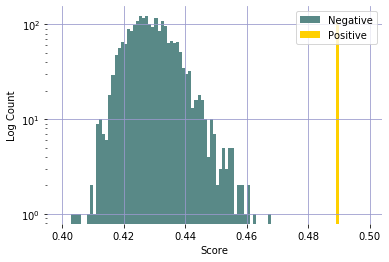

Recall of Testing = 1 : False
Testing => auc: 0.983423
Threshold is set to 0.48886483907699585
prec: 0.1298, rec: 0.9444, F1score: 0.2282
Total Positve: 18
Total Candidate: 131
----------------------------------------------
High Risk Positve: 14.0
High Risk Candidate: 61
High Risk Prec: 0.22950819672131148
----------------------------------------------
Medium Risk Positve: 3.0
Medium Risk Candidate: 70
Medium Risk Prec: 0.04285714285714286


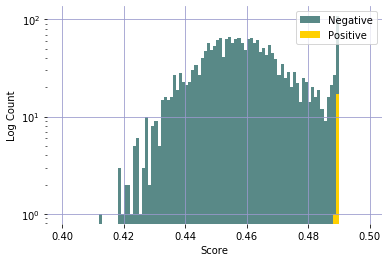

In [83]:
PATH = '../../user_data/CloudMile/data/saved_models/FeatEmbed-Conv1Dsmall_v2_eps-21_focal62_rlars_lr4_epoch1600_Part2_0.19354838709677416'
Training_label_list, Training_pred_y_list, Testing_label_list, Testing_pred_y_list= func(PATH, 'FeatEmbed-Golden-LastSoftmax')